In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import roc_auc_score

/Users/tradergllc/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv('../datasets/proc/reality-mining/txt/interim/appsByWeek.txt', 
                 sep=', ', header=None, engine='python', dtype=str, 
                 names=['id', 'date', 'app', 'freq'])

In [3]:
for r in range(len(df.index)):
    if df.iloc[r, 2].find(':') > -1:
        print df.iloc[r]
        df.iloc[r, 2] = 'Phone'

id                                                   11
date                                            2004.44
app     Phone20041027T235032area,cell,nw:5119,40791,TMO
freq                                                  1
Name: 2684, dtype: object
id                                           67
date                                    2004.41
app     Phone??20041009T021013UserActivity:idle
freq                                          1
Name: 15101, dtype: object


In [4]:
df['app'].unique().shape

(200,)

In [5]:
def convert_to_dict(df, col='app'):
    data_dict = {}
    
    unique = list(df[col].unique())
    
    pid = int(df.iloc[0,0])
    date = df.iloc[0, 1]
    data_dict[pid] = {}
    data_dict[pid][date] = np.zeros((len(unique),))
    
    for r in range(1, len(df.index)):
        if int(df.iloc[r, 0]) != pid:
            pid = int(df.iloc[r, 0])
            data_dict[pid] = {}
            date = None
        
        if df.iloc[r, 1] == date:
            data_dict[pid][date][unique.index(df.iloc[r, 2])] = df.iloc[r, 3]
        else:
            date = df.iloc[r, 1]
            data_dict[pid][date] = np.zeros((len(unique),))
            data_dict[pid][date][unique.index(df.iloc[r, 2])] = int(df.iloc[r, 3])
#             print pid, date
    return data_dict, unique

In [6]:
data_dict, unique = convert_to_dict(df)

In [7]:
def dict_to_np_array(d):
    vector_list = []
    gt_pid = []
    for pid in d.keys():
        for date in d[pid].keys():
            vector_list.append(d[pid][date])
            gt_pid.append(d.keys().index(pid))
    return np.stack(vector_list), np.array(gt_pid)

In [8]:
data, y_train = dict_to_np_array(data_dict)
print data.shape

(1911, 200)


In [9]:
data[:10]

array([[17.,  7.,  0., ...,  0.,  0.,  0.],
       [ 0.,  6.,  0., ...,  0.,  0.,  0.],
       [12.,  6.,  1., ...,  0.,  0.,  0.],
       ...,
       [14.,  7.,  0., ...,  0.,  0.,  0.],
       [ 9.,  2.,  0., ...,  0.,  0.,  0.],
       [ 7.,  2.,  0., ...,  0.,  0.,  0.]])

In [10]:
data_norm = data / data.max(axis=1)[:, None]

In [11]:
# this is the size of our encoded representations
encoding_dim = 32
input_dim = 200

# this is our input placeholder
input_img = Input(shape=(input_dim,))
x = Dense(encoding_dim, activation='relu')(input_img)
x = Dense(encoding_dim, activation='relu')(x)
encoder = Model(input_img, x, name='encoder')

encoded_ip = Input(shape=(encoding_dim,))
y = Dense(encoding_dim, activation='relu')(encoded_ip)
y = Dense(input_dim, activation='sigmoid')(y)
decoder = Model(encoded_ip, y, name='decoder')

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoder(encoder(input_img)))

In [12]:
autoencoder.compile(optimizer='adadelta', loss='categorical_crossentropy')

In [13]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
encoder (Model)              (None, 32)                7488      
_________________________________________________________________
decoder (Model)              (None, 200)               7656      
Total params: 15,144
Trainable params: 15,144
Non-trainable params: 0
_________________________________________________________________


In [14]:
autoencoder.fit(data_norm, data_norm,
                epochs=100,
                batch_size=256,
                shuffle=True)

Epoch 1/100
1911/1911 [==============================] - 0s 174us/step - loss: 11.9393
Epoch 2/100
1911/1911 [==============================] - 0s 25us/step - loss: 11.8172
Epoch 3/100
1911/1911 [==============================] - 0s 25us/step - loss: 11.2625
Epoch 4/100
1911/1911 [==============================] - 0s 25us/step - loss: 9.1678
Epoch 5/100
1911/1911 [==============================] - 0s 25us/step - loss: 5.6976
Epoch 6/100
1911/1911 [==============================] - 0s 29us/step - loss: 5.4693
Epoch 7/100
1911/1911 [==============================] - 0s 23us/step - loss: 5.4285
Epoch 8/100
1911/1911 [==============================] - 0s 23us/step - loss: 5.3524
Epoch 9/100
1911/1911 [==============================] - 0s 27us/step - loss: 5.3531
Epoch 10/100
1911/1911 [==============================] - 0s 24us/step - loss: 5.3542
Epoch 11/100
1911/1911 [==============================] - 0s 28us/step - loss: 5.3406
Epoch 12/100
1911/1911 [==============================] - 0

1911/1911 [==============================] - 0s 23us/step - loss: 4.2713
Epoch 97/100
1911/1911 [==============================] - 0s 21us/step - loss: 4.2650
Epoch 98/100
1911/1911 [==============================] - 0s 23us/step - loss: 4.2611
Epoch 99/100
1911/1911 [==============================] - 0s 21us/step - loss: 4.2565
Epoch 100/100
1911/1911 [==============================] - 0s 20us/step - loss: 4.2487


In [15]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(data_norm)
decoded_imgs = decoder.predict(encoded_imgs)

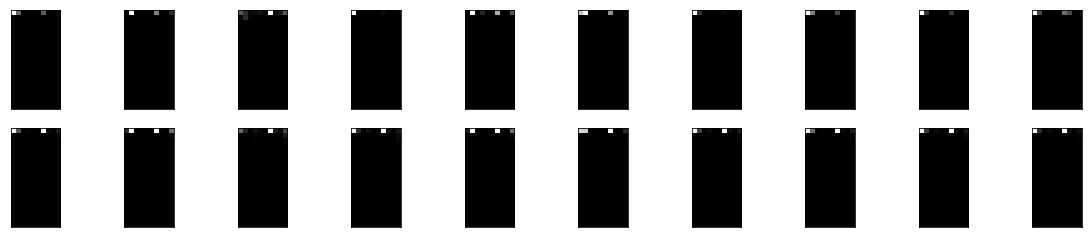

In [16]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(data_norm[i].reshape(20, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(20, 10))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [17]:
pair_dist = []
pair_label = []

for i in np.arange(encoded_imgs.shape[0]):
    for j in range(i, encoded_imgs.shape[0]):
        d = np.sqrt(np.power(encoded_imgs[i] - encoded_imgs[j], 2).sum())
        pair_dist.append(d)
        
        if y_train[i] == y_train[j]:
            pair_label.append(True)
        else:
            pair_label.append(False)
print roc_auc_score(y_true=pair_label, y_score=pair_dist)

0.3096283892574261


In [19]:
encoded_imgs.shape

(1911, 32)